In [1]:
%%capture
from jupyterthemes import jtplot
jtplot.style()
import numpy as np
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from landlab.plot.imshow import imshow_grid 
# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, FlowRouter, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure

from landlab.components.overland_flow import OverlandFlow

from landlab.plot.colors import water_colormap

# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', 
              title='Surface plot of topography', colormap = cm.gray):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = (mg.at_node[surface].reshape(mg.shape))#[y1:y2, x1:x2]
    color = colormap((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape),#[y1:y2, x1:x2]
                           mg.node_y.reshape(mg.shape),#[y1:y2, x1:x2]
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()

In [2]:
location = (r'C:/PhD/junk')
os.chdir(location)

input_geotiff = gdal.Open('fann_2013_1m0.tif')
initial_resolution = 1
x = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
input_DEM = x[1800:2000,1100:1300]

input_outlets = gdal.Open('g1_grid.tif')
initial_resolution = 1
o = np.array(input_outlets.GetRasterBand(1).ReadAsArray())
outlets = 1 - (o[1800:2000,1100:1300])

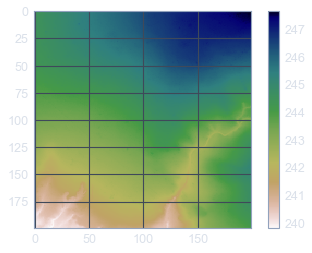

In [3]:
plt.imshow(input_DEM, cmap="gist_earth_r");
plt.colorbar();

In [4]:
def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle
def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator
def slopeWindow(DEM_slope, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM_slope[0]; b = DEM_slope[1]; c = DEM_slope[2]
    d = DEM_slope[3]; e = DEM_slope[4]; f = DEM_slope[5]
    g = DEM_slope[6]; h = DEM_slope[7]; i = DEM_slope[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but askinh for both causes it to throw and error.
    return slope_percent
# The 'extra_arguments' variable requires a value that represents r in the PCTL function defined above.
# The reason it need to be assigned to a seperate variable is that the generic_filter function only allows the
# input function (PCTL in this case) to take one argument (S1). Then, if the input function normally 
# takes more than one argument the 'extra_arguments' variable needs to be defined as a tuple 
# (hence (3,) instead of (3)).
def slopeWindowDegrees(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_degrees
def planCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
    systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    plan_curvature = (2 * (D*(H**2) + E*(G**2) - (F*G*H))) / (G**2 + H**2)
    return plan_curvature
def profileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    profile_curvature = (-2 * (D*(G**2) + E*(H**2) + (F*G*H))) / (G**2 + H**2)
    return profile_curvature
def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle
def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer.
        #Note: using median like this only gives the correct value for circles with odd 
        radius values."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value
def DFME(elev):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = elev[central_value]                        
    mean = np.nanmean(elev)#Count number of values greater than centroid value
    diff = centroid - mean
    return diff
def PCTL(x):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = x[central_value]                        
    y = np.sum(x < centroid)/num_values#Count number of values greater than centroid value
    return y
def TWI(slope, As):
    """Calculates Topographic Wetness Index (TWI) taking a slope layer in degrees,
    the catchment area of the cell calculated using a chosen flow routing algorithm and 
    the cell resolution of the slope and catchment area layers input as an integer."""
    tolerance = 1e-16
    slope_radians = np.deg2rad(slope)
    tanB = np.tan(slope_radians)
    tanB[tanB < tolerance] = tolerance
    sca = np.asarray(As)
    sca[sca < tolerance] = tolerance
    W = np.log(np.divide(sca, tanB))
    TWI = np.asarray(W)
    TWI[TWI < tolerance] = 0
    return TWI
def SPI(slope, As):
    """Calculates Compound Topographic Index (TWI) taking a slope layer in degrees and
    the catchment area of the cell calculated using a chosen flow routing algorithm."""
    tolerance = 1e-16
    slope_radians = np.deg2rad(slope)
    tanB = np.tan(slope_radians)
    tanB[tanB < tolerance] = tolerance
    C = np.multiply(As, tanB)
    C_N = np.nan_to_num(C)
    return C_N
def flow_dir_dataset(flow_receivers, grid_node_values, drainage_area,
                     grid_x_axis_length, grid_resolution, grid_shape):
    """Decomposes flow directions into 8 grids of single direction and uses those 
    grids to calculate specific catchment area."""
    array_direction = xr.Dataset();
    # In order - East, North, West, South, Nothwest, Northeast, Southwest, Southeast.
    possible_directions = [1, grid_x_axis_length, -1, -grid_x_axis_length,
                          grid_x_axis_length + 1, grid_x_axis_length - 1,
                            -(grid_x_axis_length + 1), -(grid_x_axis_length -1)]
    for i in range(0,8):
        # Reset the flow_direction grid for each run.
        flow_direction = np.subtract(flow_receivers, grid_node_values);
        # Extract only grids cells with a specific flow direction.
        isolate_direction = flow_direction == possible_directions[i]
        reshape_direction = isolate_direction.reshape(grid_shape)
        weighted_direction = xr.DataArray((np.multiply(drainage_area, reshape_direction)), 
                                          dims = ['lat', 'lon'])
        array_direction[direction_list[i]] = weighted_direction
        
    E, N, W, S, NE, NW, SW, SE = (array_direction['East'],array_direction['North'], 
                                  array_direction['West'], array_direction['South'], 
                                  array_direction['North East'], array_direction['North West'],
                                  array_direction['South West'],array_direction['South East'])

    flow_dirs = xr.concat([E, N, W, S, NE, NW, SW, SE], 'direction')
    flow_dirs.name = 'flow_directions'
    flow_dirs.attrs['grid cell resolution'] = grid_resolution
    flow_directions = flow_dirs.assign_coords(direction=(['East','North','West','South',
                                   'North East', 'North West','South West', 'South East']))
    return flow_directions
def calculate_specific_catchment_area(dir_list):
    sca_dataset = xr.Dataset()
    dir_dicts = [{'Direction': 'East', 'x1': 1, 'x2': -1, 'y1': 2, 'y2': None}, 
                {'Direction': 'North','x1': 2, 'x2': None, 'y1': 1, 'y2': -1},
                {'Direction': 'West' , 'x1': 1, 'x2': -1, 'y1': None, 'y2': -2},
                {'Direction': 'South' ,'x1': None, 'x2': -2, 'y1': 1, 'y2': -1} ,
                {'Direction': 'North East' , 'x1': 2, 'x2': None, 'y1': 2, 'y2': None},
                {'Direction': 'North West' , 'x1': 2, 'x2': None, 'y1': None, 'y2': -2},
                {'Direction': 'South West' , 'x1': None, 'x2': -2, 'y1': None, 'y2': -2},
                {'Direction': 'South East', 'x1': None, 'x2': -2, 'y1': 2, 'y2': None}]

    for varname, ds in catchment_area_grids.data_vars.items():
        loop_temp_ds = xr.Dataset();
        for i in range(0,8):
                buffer = ds.sel(direction = dir_list[i]);
                resolution = buffer.attrs['grid cell resolution'];
                if i < 4:
                    flow_width_factor = np.divide(1, np.float(resolution));
                else: 
                    flow_width_factor = np.divide(1, math.sqrt(2) * resolution);
                
                lat = buffer.shape[0]; lon = buffer.shape[1];
                exp = np.zeros((lat + 2,lon + 2));
                exp[dir_dicts[i]['x1']:dir_dicts[i]['x2'],
                dir_dicts[i]['y1']:dir_dicts[i]['y2']] = np.multiply(buffer, flow_width_factor);
                spca_shell = np.flip(exp [1:-1,1:-1], 0);
                spca = xr.DataArray(spca_shell, dims = ['lat', 'lon']);
                loop_temp_ds[dir_list[i]] = spca
                
        E, N, W, S, NE, NW, SW, SE = (loop_temp_ds['East'], loop_temp_ds['North'],
                                loop_temp_ds['West'], loop_temp_ds['South'],
                                loop_temp_ds['North East'], loop_temp_ds['North West'],
                                loop_temp_ds['South West'], loop_temp_ds['South East']);

        spca_dirs = xr.concat([E, N, W, S, NE, NW, SW, SE], 'direction');
        specific_ca = spca_dirs.sum('direction');
        specific_ca.attrs['grid cell resolution'] = resolution
        sca_dataset['sca' + '_' + varname] = specific_ca
        
    return sca_dataset
def compile_flow_width_grid(flow_direction_grids, resolution, grid_shape):
    discharge_factor = np.zeros(grid_shape)
    for i in range(0, 8):
        if i < 4:
            flow_width_factor = np.divide(1, np.float(resolution));
        else: 
            flow_width_factor = np.divide(1, math.sqrt(2) * resolution);
        isolate_direction = flow_direction_grids[i,:,:] != 0;
        flow_width = np.multiply(isolate_direction, flow_width_factor);
        discharge_factor += flow_width
    return discharge_factor     

## First clip out the watershed

In [5]:
flow_acc_surf = np.copy(input_DEM).astype('float64');
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

In [6]:
sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorD8');
(flow_acc, q) = fa.accumulate_flow();
fd = FlowDirectorD8(mg, 'topographic__elevation');
fd.direct_flow();

In [7]:
grid_nodes_outlet = np.array(mg.nodes.reshape(mg.shape))
drainage_area = np.array(mg.at_node['drainage_area']).reshape(mg.shape).astype('float64');

In [8]:
find_outlet_ids = grid_nodes_outlet * outlets

In [9]:
outlet_id = np.unique(find_outlet_ids)[1]

In [10]:
watershed_mask = np.array(get_watershed_mask(mg, outlet_id).reshape(mg.shape).astype(int))

In [11]:
watershed_D8 = np.multiply(watershed_mask, drainage_area)

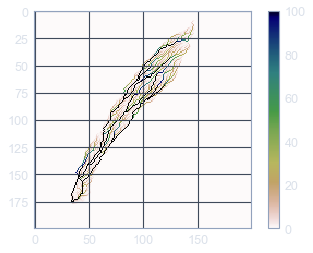

In [12]:
plt.imshow(watershed_D8, cmap="gist_earth_r", vmax = 100);
plt.colorbar();

In [13]:
watershed_dem = np.multiply(watershed_mask, input_DEM)

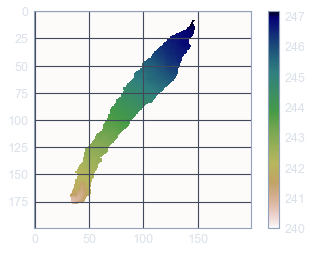

In [14]:
plt.imshow(watershed_dem, cmap="gist_earth_r", vmin = 240);
plt.colorbar();

In [15]:
flow_acc_surf = np.copy(watershed_dem).astype('float64');
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg2 = RasterModelGrid((rows,cols), 1);
z2 = mg2.add_field('topographic__elevation', flow_acc_surf, at = 'node');

In [16]:
mg2.set_watershed_boundary_condition(z2,0)

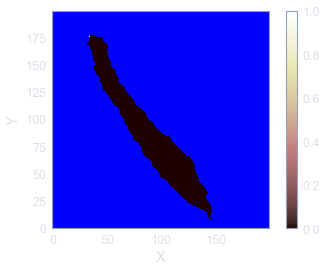

In [17]:
imshow_grid(mg2, mg2.status_at_node, color_for_closed='blue')

In [18]:
sfb = SinkFillerBarnes(mg2, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();

In [19]:
run_time = 1200          # duration of run, (s)
storm_duration = 1200.0
h_init = 0.0001              # initial thin layer of water (m)
n = 0.01                  # roughness coefficient, (s/m^(1/3))
g = 9.8                   # gravity (m/s^2)
alpha = 0.7               # time-step factor (nondimensional; from Bates et al., 2010)
u = 0.4                   # constant velocity (m/s, de Almeida et al., 2012)
run_time_slices = (300,600,1200)

In [20]:
elapsed_time = 0.0

In [21]:
#for stability in steeper environments, set the steep_slopes flag to True
#
rain_mm_p_h = 50
of = OverlandFlow(mg2, steep_slopes=True , rainfall_intensity = rain_mm_p_h/3600/1000) 

In [22]:
outlet_link = mg2.links_at_node[outlet_id][0]

In [23]:
outlet_id

35234

In [24]:
mg2.nodes_at_link[outlet_link]

array([35234, 35235])

In [25]:
mg2.at_node.keys()

dict_keys(['topographic__elevation', 'sediment_fill__depth', 'surface_water__depth'])

In [26]:
hydrograph_time = []
discharge_at_outlet = []
water_depth_at_outlet = []

In [27]:
while elapsed_time < run_time:
    hydrograph_time.append(elapsed_time / 3600.)  # convert seconds to hours
    # First, we calculate our time step.
    dt = of.calc_time_step()
    if elapsed_time < (storm_duration):
        of.rainfall_intensity =  rain_mm_p_h/3600/1000
    else:
            of.rainfall_intensity = 0.0
    # Now, we can generate overland flow.
    of.overland_flow()
    discharge_at_outlet.append(np.abs(of.q[outlet_link]) * mg2.dx) # append discharge in m^3/s
    water_depth_at_outlet.append(np.abs(mg2.at_node['surface_water__depth'][35235])) 
    # append depth in m.
    # Increased elapsed time
    print('Elapsed time: ', elapsed_time)
    elapsed_time += dt

Elapsed time:  0.0
Elapsed time:  70.6746288285
Elapsed time:  77.7506160974
Elapsed time:  83.1213010874
Elapsed time:  87.6907490941
Elapsed time:  91.6572131696
Elapsed time:  95.2875344056
Elapsed time:  98.6386250518
Elapsed time:  101.77695557
Elapsed time:  104.710537408
Elapsed time:  107.482680547
Elapsed time:  110.121209697
Elapsed time:  112.660809934
Elapsed time:  115.106242467
Elapsed time:  117.487282831
Elapsed time:  119.782795795
Elapsed time:  122.036854598
Elapsed time:  124.223153166
Elapsed time:  126.371058295
Elapsed time:  128.45795675
Elapsed time:  130.511657035
Elapsed time:  132.51070324
Elapsed time:  134.480936999
Elapsed time:  136.396978964
Elapsed time:  138.28497856
Elapsed time:  140.136899416
Elapsed time:  141.968485236
Elapsed time:  143.766092203
Elapsed time:  145.549270274
Elapsed time:  147.304577905
Elapsed time:  149.047103282
Elapsed time:  150.766785267
Elapsed time:  152.474908417
Elapsed time:  154.165644233
Elapsed time:  155.843917688

Elapsed time:  428.789018108
Elapsed time:  429.697802858
Elapsed time:  430.605672808
Elapsed time:  431.512595459
Elapsed time:  432.418590057
Elapsed time:  433.323624538
Elapsed time:  434.227720293
Elapsed time:  435.130843597
Elapsed time:  436.033017002
Elapsed time:  436.934203858
Elapsed time:  437.834429619
Elapsed time:  438.733651733
Elapsed time:  439.631898048
Elapsed time:  440.529125906
Elapsed time:  441.425370064
Elapsed time:  442.32058513
Elapsed time:  443.21480594
Elapsed time:  444.107984386
Elapsed time:  445.000158963
Elapsed time:  445.891276224
Elapsed time:  446.781378044
Elapsed time:  447.670410484
Elapsed time:  448.558420661
Elapsed time:  449.445352175
Elapsed time:  450.331254716
Elapsed time:  451.216087539
Elapsed time:  452.09988875
Elapsed time:  452.982682861
Elapsed time:  453.864431439
Elapsed time:  454.745138638
Elapsed time:  455.62477468
Elapsed time:  456.503349898
Elapsed time:  457.380849341
Elapsed time:  458.257298336
Elapsed time:  459

Elapsed time:  650.388334395
Elapsed time:  651.040567591
Elapsed time:  651.69257049
Elapsed time:  652.34442525
Elapsed time:  652.99606913
Elapsed time:  653.647584873
Elapsed time:  654.298909692
Elapsed time:  654.950130091
Elapsed time:  655.601186383
Elapsed time:  656.252164455
Elapsed time:  656.90300248
Elapsed time:  657.553780702
Elapsed time:  658.204430051
Elapsed time:  658.855026272
Elapsed time:  659.50549967
Elapsed time:  660.155925851
Elapsed time:  660.806234177
Elapsed time:  661.45649952
Elapsed time:  662.106646277
Elapsed time:  662.756741346
Elapsed time:  663.406706923
Elapsed time:  664.056615202
Elapsed time:  664.706398346
Elapsed time:  665.356137623
Elapsed time:  666.005760494
Elapsed time:  666.655331833
Elapsed time:  667.304769004
Elapsed time:  667.95414309
Elapsed time:  668.603378977
Elapsed time:  669.252550089
Elapsed time:  669.901583583
Elapsed time:  670.550550422
Elapsed time:  671.199372583
Elapsed time:  671.848123049
Elapsed time:  672.49

Elapsed time:  834.311572074
Elapsed time:  834.958923214
Elapsed time:  835.606253437
Elapsed time:  836.253643691
Elapsed time:  836.901022074
Elapsed time:  837.548452922
Elapsed time:  838.195853703
Elapsed time:  838.843297101
Elapsed time:  839.490716426
Elapsed time:  840.138193207
Elapsed time:  840.785656674
Elapsed time:  841.433173864
Elapsed time:  842.080663314
Elapsed time:  842.728195718
Elapsed time:  843.375702346
Elapsed time:  844.023260701
Elapsed time:  844.67080111
Elapsed time:  845.318396378
Elapsed time:  845.96596855
Elapsed time:  846.613585059
Elapsed time:  847.261171482
Elapsed time:  847.908804018
Elapsed time:  848.556410413
Elapsed time:  849.204065081
Elapsed time:  849.851696989
Elapsed time:  850.499378987
Elapsed time:  851.147034311
Elapsed time:  851.794732402
Elapsed time:  852.4423999
Elapsed time:  853.090109849
Elapsed time:  853.737791598
Elapsed time:  854.385521842
Elapsed time:  855.033227768
Elapsed time:  855.680977264
Elapsed time:  856

Text(0.5, 1.0, 'Outlet Hydrograph, Rainfall: 50 mm/hr over 0.3 hours')

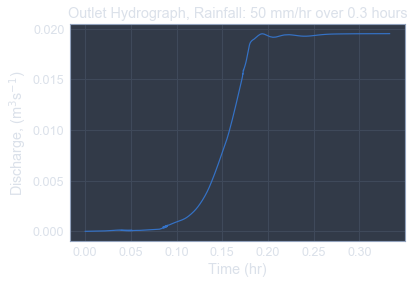

In [28]:
plt.plot(hydrograph_time, discharge_at_outlet)
plt.ylabel('Discharge, (m$^3$s$^{-1}$)')
plt.xlabel('Time (hr)')
plt.title('Outlet Hydrograph, Rainfall: ' + str(rain_mm_p_h) + 
          ' mm/hr ' + 'over ' + str((elapsed_time / 3600.).round(1)) + ' hours')

In [1]:
6.89*(0.02**0.45)

1.1849027842129747

Text(0.5, 1.0, 'Outlet Depth, Rainfall: 50 mm/hr over 0.3 hours')

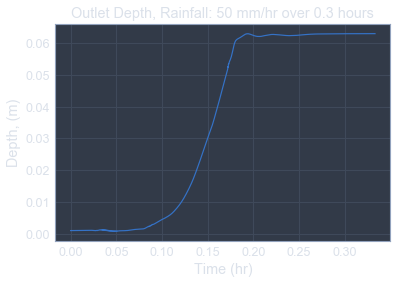

In [29]:
plt.plot(hydrograph_time, water_depth_at_outlet);
plt.ylabel('Depth, (m)');
plt.xlabel('Time (hr)');
plt.title('Outlet Depth, Rainfall: ' + str(rain_mm_p_h) + 
          ' mm/hr ' + 'over ' + str((elapsed_time / 3600.).round(1)) + ' hours');

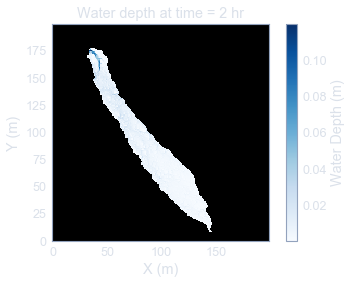

In [31]:
imshow_grid(mg2, 'surface_water__depth', plot_name='Water depth at time = 2 hr',
        var_name='Water Depth', var_units='m', grid_units=('m', 'm'), cmap='Blues')

In [ ]:
while elapsed_time < run_time:
    hydrograph_time.append(elapsed_time / 3600.)  # convert seconds to hours
    of.dt = of.calc_time_step()     # Adaptive time step
    if elapsed_time < (storm_duration):
            of.rainfall_intensity =  rainfall_mmhr * (2.777778 * 10**-7)
    else:
            of.rainfall_intensity = 0.0
    of.overland_flow()
    mg2.at_node['surface_water__discharge'] = of.discharge_mapper(of.q, convert_to_volume=True)
    discharge_at_outlet.append(np.abs(of.q[outlet_link]) * mg2.dx) # append discharge in m^3/s
    elapsed_time += of.dt

In [36]:
swd = np.array(mg2.at_node['surface_water__depth']).reshape(mg.shape).astype('float64');

In [37]:
san = np.array(mg2.status_at_node).reshape(mg.shape).astype('float64');

In [38]:
mask_closed_nodes = san != 4

In [39]:
water_depth = np.multiply(swd, mask_closed_nodes)

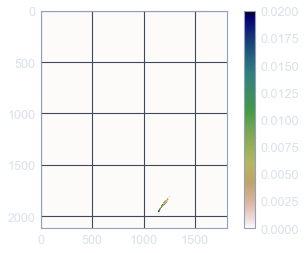

In [51]:
plt.imshow(water_depth, cmap="gist_earth_r", vmax = 0.02);
plt.colorbar();

In [ ]:
imshow_grid(mg2, 'surface_water__depth', cmap='Blues')

In [48]:
c = np.zeros([2,2])
c

array([[ 0.,  0.],
       [ 0.,  0.]])

In [50]:
empty_grid = np.zeros([x.shape[0], x.shape[1]])
empty_grid[1800:2000,1100:1300] = water_depth

In [ ]:
plt.imshow(empty_grid, cmap="gist_earth_r", vmax = 0.02);
plt.colorbar();

In [52]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [53]:
np_array_to_Geotiff('depth_test.tif', input_geotiff, empty_grid, water_depth.dtype)

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
